<a href="https://colab.research.google.com/github/Karishma-Kuria/ML-GMM-Clustering/blob/main/Clustering_GMM_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset: Football Events**

The dataset contains details of 9,074 games, totaling 941,009 events which were played in the biggest 5 European football leagues: Spain, England, Germany, Italy, France from 2011/2012 season to 2016/2017 season as of 25.01.2017.
The dataset contains 3 files:
1. dictionary.txt
2.events.csv
3. ginf.csv

The main aim of this notebook is to perform data wrangling, data preparation, EDA and clustering using KMean Algorithm by Scikit and Pytorch.

In [101]:
# importing the relevant libraries
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib as mp
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import drive
#drive.mount('/gdrive')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
event_path = "/content/drive/My Drive/ML_DataSet/events.csv"
info_path = "/content/drive/My Drive/ML_DataSet/ginf.csv"
dict_path = "/content/drive/My Drive/ML_DataSet/dictionary.txt"

## Loading Dataset

In [103]:
# addresses of the csv in the dataset

game_events = pd.read_csv(event_path, engine="python")
game_info = pd.read_csv(info_path, engine="python")

In [104]:
# lets take a look at the info of the columns in the first table
game_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [105]:
# check the first 5 rows of the events table
game_events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [106]:
# checkfor duplicate values
sum(game_events.duplicated())

0

In [107]:
# check for the count of missing values
game_events.isnull().sum()

id_odsp               0
id_event              0
sort_order            0
time                  0
text                  0
event_type            0
event_type2      726716
side                  0
event_team            0
opponent              0
player            61000
player2          649699
player_in        889294
player_out       889271
shot_place       713550
shot_outcome     712511
is_goal               0
location         473942
bodypart         711824
assist_method         0
situation        711872
fast_break            0
dtype: int64

From the above step, I have observed that there are null values in the below columns:

1.  event_type2
2.  player
3. player2
4. player_in
5. player_out
6. shot_place
7. shot_outcome
8. location
9. bodypart
10. situation



In [108]:
# replacing the missing values
game_events.fillna(0, inplace = True)
game_events.isnull().sum()

id_odsp          0
id_event         0
sort_order       0
time             0
text             0
event_type       0
event_type2      0
side             0
event_team       0
opponent         0
player           0
player2          0
player_in        0
player_out       0
shot_place       0
shot_outcome     0
is_goal          0
location         0
bodypart         0
assist_method    0
situation        0
fast_break       0
dtype: int64

In [109]:
# check the first 5 rows of the info table
game_info.shape
game_info.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


# **EDA**

Mapping the column values with the values in the dictionary to visualize the data in graphs.

In [110]:
encoding_dict = pd.read_table(dict_path, delim_whitespace = False, names = ('nums', 'events'))
# mapping the Column values from dictionary to the cloumns of events dataset
event_type = encoding_dict[1:13]
event_type2 = encoding_dict[14:18]
side = encoding_dict[19:21]
shot_place = encoding_dict[22:35]
shot_outcome = encoding_dict[36:40]
location = encoding_dict[41:60]
bodypart = encoding_dict[61:64]
assist_method = encoding_dict[65:70]
situation = encoding_dict[71:75]

In [111]:
# check if the values are mapped properly
event_type

,nums,events
1,0,Announcement
2,1,Attempt
3,2,Corner
4,3,Foul
5,4,Yellow card
6,5,Second yellow card
7,6,Red card
8,7,Substitution
9,8,Free kick won
10,9,Offside


In [112]:
# check if the values are mapped properly
side

,nums,events
19,1,Home
20,2,Away


### **Here I have plotted the graph between "Number of Goals" (by home/away side) and "Minutes" in a match.**

In [113]:
# get all the records where the goal was scored
goals_scored=game_events[game_events["is_goal"]==1]
goals_scored

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,0,0,4.0,1.0,1,9.0,2.0,1,1.0,0
26,UFot0hit/,UFot0hit27,27,29,"Goal! Borussia Dortmund 2, Hamburg 0. Mario G...",1,12.0,1,Borussia Dortmund,Hamburg SV,mario gotze,robert lewandowski,0,0,5.0,1.0,1,3.0,1.0,1,1.0,0
50,UFot0hit/,UFot0hit51,51,49,"Goal! Borussia Dortmund 3, Hamburg 0. Kevin G...",1,0.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,0,0,0,4.0,1.0,1,13.0,1.0,0,3.0,0
92,UFot0hit/,UFot0hit93,93,80,"Goal! Borussia Dortmund 3, Hamburg 1. Robert ...",1,0.0,2,Hamburg SV,Borussia Dortmund,robert tesche,0,0,0,3.0,1.0,1,3.0,2.0,0,3.0,0
175,Aw5DflLH/,Aw5DflLH66,66,48,"Goal! FC Augsburg 0, SC Freiburg 1. Papiss De...",1,12.0,2,SC Freiburg,FC Augsburg,papiss demba cisse,felix bastians,0,0,3.0,1.0,1,15.0,1.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940713,xY7uZwOI/,xY7uZwOI26,26,24,"Goal! Monaco 1, Lorient 0. Boschilia (Monaco)...",1,0.0,1,AS Monaco,Lorient,boschilia,0,0,0,5.0,1.0,1,3.0,2.0,0,1.0,0
940716,xY7uZwOI/,xY7uZwOI29,29,28,"Goal! Monaco 2, Lorient 0. Boschilia (Monaco)...",1,12.0,1,AS Monaco,Lorient,boschilia,bernardo silva,0,0,4.0,1.0,1,9.0,2.0,1,1.0,0
940722,xY7uZwOI/,xY7uZwOI35,35,37,"Goal! Monaco 3, Lorient 0. Valere Germain (Mo...",1,0.0,1,AS Monaco,Lorient,valere germain,0,0,0,4.0,1.0,1,9.0,1.0,0,1.0,0
940742,xY7uZwOI/,xY7uZwOI58,58,59,"Goal! Monaco 4, Lorient 0. Valere Germain (Mo...",1,12.0,1,AS Monaco,Lorient,valere germain,djibril sidibe,0,0,5.0,1.0,1,11.0,1.0,1,1.0,0


Text(0.5, 1.0, 'Number of goals (by home/away side) against Time during match')

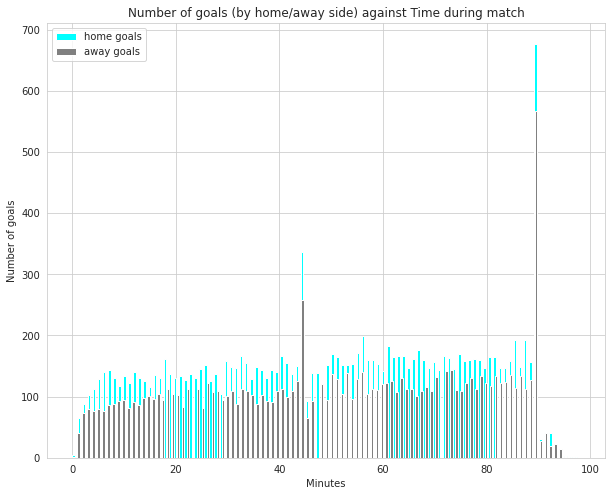

In [114]:
fig = plot.figure(figsize=(10,8))
plot.hist(goals_scored[goals_scored["side"]==1]["time"],width=0.5,bins=100,color="cyan",label="home goals")   
plot.hist(goals_scored[goals_scored["side"]==2]["time"],width=0.5,bins=100,color="grey",label="away goals") 
plot.xlabel("Minutes")
plot.ylabel("Number of goals")
plot.legend()
plot.title("Number of goals (by home/away side) against Time during match")

### From the above graph we can infer that maximum number of goals were scored between 40 to 50 minutes in a match by both Home and away Team. 

### Let's Visualize the count of red cards the Home and Away teams got. 

In [115]:
# filtering data to get the count of total red cards 
yellow_second_card=game_events[game_events["event_type"]==5]
red_card=game_events[game_events["event_type"]==6]
reds_total=[yellow_second_card,red_card]
total_red_cards=pd.concat(reds_total)
total_red_cards.event_type.unique()

array([5, 6])

,home,away
Red cards,548,704


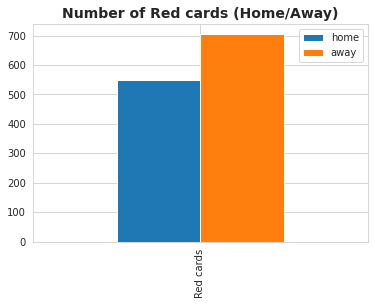

In [116]:
red_home=total_red_cards[total_red_cards["side"]==1].shape[0]
red_away=total_red_cards[total_red_cards["side"]==2].shape[0]

red_combined=pd.DataFrame({"home":red_home,"away":red_away},index=["Red cards"])
red_combined.plot(kind="bar")
plot.title("Number of Red cards (Home/Away)",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
red_combined

### From the above graph its pretty clear that Home team has played much better since they got less number of Red cards as compared to the Away Team.

In [117]:
# common function to plot bar plots with following configuration
def barplot(data, x_ticks, x_labels, y_labels, title, color='muted', num=10, figsize=8):
    # set whitegrid as style
    sns.set_style("whitegrid")
    
    plot.figure(figsize=(num, figsize))
    # plot data
    bx = sns.barplot(x = [j for j in range(0, len(data))], y=data.values, palette=color)
    # set ticks 
    bx.set_xticks([j for j in range(0, len(data))])
    # set labels on the chart
    bx.set_xticklabels(x_ticks, rotation=45)
    bx.set(xlabel = x_labels, ylabel = y_labels, title = title)
    bx.plot();
    plot.tight_layout()

## **Which Teams are most offensive in the matches played?**

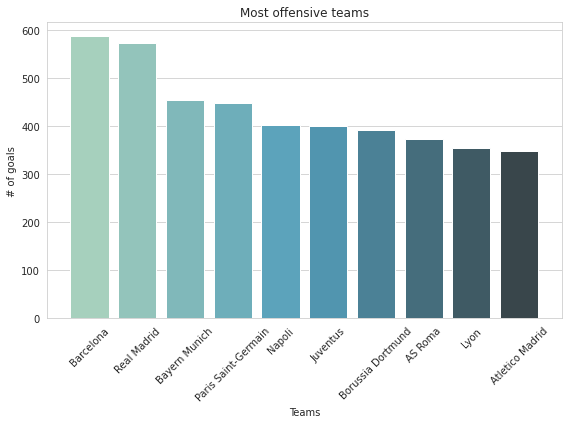

In [118]:
# group attempts by team
group_by_offensive = game_events[game_events['is_goal']==1].groupby('event_team')

# sort the values grouped
group_by_offensive = group_by_offensive.count().sort_values(by='id_event', ascending=False)[:10]
teams = group_by_offensive.index
scores = group_by_offensive['id_event']

# plot the teams
barplot(scores, teams, 'Teams', '# of goals', 'Most offensive teams', 'GnBu_d', 8, 6)

### The above graph shows an interesting goal scores for the top teams. Barcelona tops this tally, rest of the teams also have scored good number of goals. 
### Similar to the above graph, I can also plot the graph to see the most offensive players in the league. 

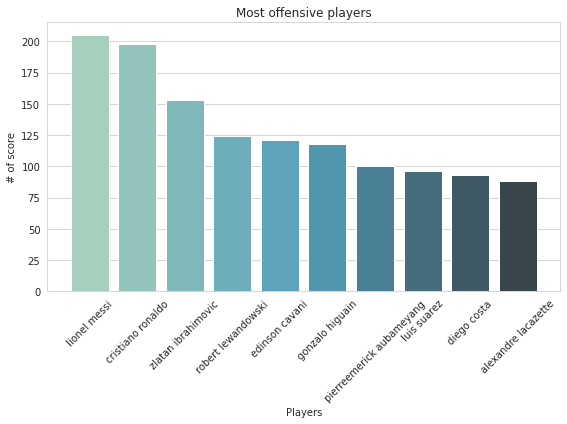

In [119]:
# group by player if the goal is scored
group_by_player = game_events[game_events['is_goal']==1].groupby('player')

# count and sort the number of goals by player and pick top 10
group_by_offensive_player = group_by_player.count().sort_values(by='id_event',
                                                                                ascending=False)[:10]
# extract player names
players = group_by_offensive_player.index
# extract number of goals
scores = group_by_offensive_player['id_event']
# plot the graph
barplot(scores, players, 'Players', '# of score', 'Most offensive players', 'GnBu_d', 8, 6)

Clearly Lionel Messi and Ronaldo are the most Offensive players in the top 10 most offensive teams in the league.

# **Clustering**

## The main aim here is to cluster the teams which participated in the league matches on the basis of their playing style.


As a part of this I have used parameters such as events (fouls, attempts, ...), locations (midfield,wings,etc ...), assist methods (crosses,short passes ...), situations (different set pieces and open play) and involved body parts(both feet and head).

# **Feature Selection**

In [120]:
# count all the required parameter and then group them based on teams
# select relevant feature from the dataset
game_df = game_events[['event_team','event_type', 'event_type2','location', 'assist_method', 'situation', 'bodypart']]
game_df.groupby('event_team')
game_df2 = game_df.groupby('event_team', group_keys=False)
k = game_df['event_team'].sort_values().unique()

appended_data = []
# create column for all the values of the above features selected
for col in game_df.columns[game_df.columns != 'event_team']: 
    appended_data.append(game_df2[col].value_counts(dropna=True).sort_index().unstack(col).add_prefix(col+'_'))

game_df3 = pd.concat(appended_data, axis=1)    
game_df3['Event team'] = k
game_df3.head()


,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type2_0.0,event_type2_12.0,event_type2_13.0,event_type2_14.0,event_type2_15.0,location_0.0,location_1.0,location_2.0,location_3.0,location_4.0,location_5.0,location_6.0,location_7.0,location_8.0,location_9.0,location_10.0,location_11.0,location_12.0,location_13.0,location_14.0,location_15.0,location_16.0,location_17.0,location_18.0,location_19.0,assist_method_0,assist_method_1,assist_method_2,assist_method_3,assist_method_4,situation_0.0,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_0.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,Event team
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,1106.0,449.0,1593.0,238.0,NaN,12.0,307.0,1534.0,365.0,96.0,15.0,4567.0,762.0,365.0,17.0,4.0,3075.0,285.0,850.0,336.0,212.0,187.0,9.0,9.0,10.0,71.0,13.0,92.0,12.0,27.0,15.0,457.0,24.0,20.0,3.0,8.0,4953.0,490.0,198.0,43.0,31.0,4609,913,86,74,33,4609,566,374,166,AC Ajaccio
AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,42.0,8840.0,2200.0,543.0,39.0,11.0,5728.0,673.0,1484.0,784.0,344.0,339.0,10.0,28.0,35.0,215.0,34.0,256.0,29.0,93.0,51.0,1465.0,23.0,19.0,1.0,22.0,9433.0,1556.0,477.0,61.0,106.0,8568,2615,144,219,87,8568,1936,788,341,AC Milan
AJ Auxerre,446.0,178.0,558.0,89.0,NaN,3.0,104.0,469.0,94.0,35.0,8.0,1583.0,302.0,94.0,5.0,NaN,1069.0,108.0,237.0,123.0,70.0,54.0,6.0,4.0,4.0,48.0,10.0,33.0,10.0,18.0,1.0,173.0,5.0,8.0,1.0,2.0,1682.0,174.0,92.0,16.0,20.0,1538,364,18,41,23,1538,199,178,69,AJ Auxerre
AS Monaco,1665.0,727.0,1666.0,243.0,NaN,8.0,385.0,1736.0,285.0,106.0,29.0,5328.0,1219.0,285.0,11.0,7.0,3449.0,407.0,848.0,558.0,221.0,260.0,8.0,19.0,16.0,131.0,32.0,128.0,44.0,56.0,26.0,607.0,11.0,9.0,2.0,18.0,5631.0,754.0,363.0,49.0,53.0,5185,1387,86,142,50,5185,797,574,294,AS Monaco
AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,NaN,7.0,232.0,1174.0,254.0,67.0,12.0,3526.0,791.0,254.0,8.0,1.0,2348.0,239.0,618.0,261.0,172.0,145.0,7.0,11.0,4.0,85.0,15.0,82.0,14.0,28.0,10.0,502.0,17.0,16.0,2.0,4.0,3789.0,523.0,193.0,42.0,33.0,3522,874,69,86,29,3522,651,239,168,AS Nancy Lorraine


### Since various teams can have different number of games, I haved counted games for each team both home and away. After counting I have normalize all features by the total number of games.

In [121]:
game = game_info['ht'].value_counts() + game_info['at'].value_counts()

game_df3['games'] = game
game_df3.head(5)

for i in game_df3.columns:
    if (type(game_df3[i][0]) == np.float64) | (type(game_df3[i][0]) == np.int64):
        game_df3[i] = game_df3[i].div(game, axis=0)

In [122]:
# get rid of all the decimal numbers in the column names
game_df3.rename(columns={'location_10.0': 'location_10'}, inplace = True)

for col in game_df3.columns:   
    if col.endswith('.0'):
        col1 = col.strip('.0')
    else:
        col1 = col
    game_df3 = game_df3.rename(columns={col : col1})   

print(game_df3.columns)


Index(['event_type_1', 'event_type_2', 'event_type_3', 'event_type_4',
       'event_type_5', 'event_type_6', 'event_type_7', 'event_type_8',
       'event_type_9', 'event_type_10', 'event_type_11', 'event_type2_',
       'event_type2_12', 'event_type2_13', 'event_type2_14', 'event_type2_15',
       'location_', 'location_1', 'location_2', 'location_3', 'location_4',
       'location_5', 'location_6', 'location_7', 'location_8', 'location_9',
       'location_10', 'location_11', 'location_12', 'location_13',
       'location_14', 'location_15', 'location_16', 'location_17',
       'location_18', 'location_19', 'assist_method_0', 'assist_method_1',
       'assist_method_2', 'assist_method_3', 'assist_method_4', 'situation_',
       'situation_1', 'situation_2', 'situation_3', 'situation_4', 'bodypart_',
       'bodypart_1', 'bodypart_2', 'bodypart_3', 'Event team', 'games'],
      dtype='object')


### **Mapping the parameter names with the names provided in the dictionary.**

In [123]:
from re import A
f = open(dict_path,"r")
a = []
b = []
r = []
for lines in f:
    a.append(lines.split())

line_base = a[0][0]

for line in a:
    if len(line) > 1:        
        ll = ''
        for j in range(1, len(line)):
            if j < (len(line) - 1):
                ll = ll + line[j] + ' '
            else:
                ll = ll + line[j]
        b.append([line_base + '_' + line[0], ll])
                
    elif len(line) == 1:
        line_base = line[0]
print(b)

[['event_type_0', 'Announcement'], ['event_type_1', 'Attempt'], ['event_type_2', 'Corner'], ['event_type_3', 'Foul'], ['event_type_4', 'Yellow card'], ['event_type_5', 'Second yellow card'], ['event_type_6', 'Red card'], ['event_type_7', 'Substitution'], ['event_type_8', 'Free kick won'], ['event_type_9', 'Offside'], ['event_type_10', 'Hand ball'], ['event_type_11', 'Penalty conceded'], ['event_type2_12', 'Key Pass'], ['event_type2_13', 'Failed through ball'], ['event_type2_14', 'Sending off'], ['event_type2_15', 'Own goal'], ['side_1', 'Home'], ['side_2', 'Away'], ['shot_place_1', 'Bit too high'], ['shot_place_2', 'Blocked'], ['shot_place_3', 'Bottom left corner'], ['shot_place_4', 'Bottom right corner'], ['shot_place_5', 'Centre of the goal'], ['shot_place_6', 'High and wide'], ['shot_place_7', 'Hits the bar'], ['shot_place_8', 'Misses to the left'], ['shot_place_9', 'Misses to the right'], ['shot_place_10', 'Too high'], ['shot_place_11', 'Top centre of the goal'], ['shot_place_12', 

In [124]:
i = 0
for col in b:    
    if col[0] in game_df3.columns:        
        game_df3 = game_df3.rename(columns={col[0] : col[1]})
    
print(game_df3.columns)

Index(['Attempt', 'Corner', 'Foul', 'Yellow card', 'Second yellow card',
       'Red card', 'Substitution', 'Free kick won', 'Offside', 'Hand ball',
       'Penalty conceded', 'event_type2_', 'Key Pass', 'Failed through ball',
       'Sending off', 'Own goal', 'location_', 'Attacking half',
       'Defensive half', 'Centre of the box', 'Left wing', 'Right wing',
       'Difficult angle and long range', 'Difficult angle on the left',
       'Difficult angle on the right', 'Left side of the box',
       'Left side of the six yard box', 'Right side of the box',
       'Right side of the six yard box', 'Very close range', 'Penalty spot',
       'Outside the box', 'Long range', 'More than 35 yards',
       'More than 40 yards', 'Not recorded', 'None', 'Pass', 'Cross',
       'Headed pass', 'Through ball', 'situation_', 'Open play', 'Set piece',
       'Corner', 'Free kick', 'bodypart_', 'right foot', 'left foot', 'head',
       'Event team', 'games'],
      dtype='object')


In [126]:
# dropping not recorded values
game_df3.drop('Not recorded', axis=1, inplace=True)

In [127]:
# merge columns since playing style is not distinguish by right from left.
def col_sum(a1,b1):
    c1 = game_df3[[a1,b1]].sum(axis=1)    
    game_df3.drop([a1,b1], axis=1, inplace=True)
    return c1    

game_df3['Foot'] = col_sum('right foot','left foot')
game_df3['Wing'] = col_sum('Right wing','Left wing')
game_df3['Difficult angle'] = col_sum('Difficult angle on the left','Difficult angle on the right')
game_df3['Side of the box'] = col_sum('Left side of the box','Right side of the box')
game_df3['Side of the six yard box'] = col_sum('Left side of the six yard box','Right side of the six yard box')

Doing some cleaning in the data.

In [128]:
game_df3.rename(columns={'head': 'Head'}, inplace = True) 
game_df3.drop('games', axis=1, inplace=True)
game_df3.drop('Second yellow card', axis=1, inplace=True)


In [129]:
game_df3.dropna(axis=0,inplace=True)
game_df3.drop('Event team', axis=1, inplace=True)

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,event_type2_,Key Pass,Failed through ball,Sending off,Own goal,location_,Attacking half,Defensive half,Centre of the box,Difficult angle and long range,Very close range,Penalty spot,Outside the box,Long range,More than 35 yards,More than 40 yards,None,Pass,Cross,Headed pass,Through ball,situation_,Open play,Set piece,Corner,Free kick,bodypart_,Head,Event team,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,40.061404,6.684211,3.201754,0.149123,0.035088,26.973684,2.500000,7.456140,2.947368,0.078947,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,43.447368,4.298246,1.736842,0.377193,0.271930,40.429825,8.008772,0.754386,0.649123,0.289474,40.429825,1.456140,AC Ajaccio,8.245614,3.500000,0.166667,1.429825,0.219298
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,42.095238,10.476190,2.585714,0.185714,0.052381,27.276190,3.204762,7.066667,3.733333,0.047619,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,44.919048,7.409524,2.271429,0.290476,0.504762,40.800000,12.452381,0.685714,1.042857,0.414286,40.800000,1.623810,AC Milan,12.971429,3.252381,0.300000,2.242857,0.300000
AS Monaco,12.333333,5.385185,12.340741,1.800000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,39.466667,9.029630,2.111111,0.081481,0.051852,25.548148,3.014815,6.281481,4.133333,0.059259,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,41.711111,5.585185,2.688889,0.362963,0.392593,38.407407,10.274074,0.637037,1.051852,0.370370,38.407407,2.177778,AS Monaco,10.155556,3.562963,0.259259,1.918519,0.562963
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,36.729167,8.239583,2.645833,0.083333,0.010417,24.458333,2.489583,6.437500,2.718750,0.072917,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,39.468750,5.447917,2.010417,0.437500,0.343750,36.687500,9.104167,0.718750,0.895833,0.302083,36.687500,1.750000,AS Nancy Lorraine,9.270833,3.302083,0.156250,1.739583,0.302083
AS Roma,15.509524,6.019048,11.914286,2.304762,0.080952,2.833333,13.100000,2.176190,0.547619,0.190476,40.690476,11.642857,2.176190,0.138095,0.028571,26.066667,3.161905,7.104762,4.190476,0.128571,0.428571,0.185714,6.757143,0.123810,0.095238,0.014286,43.033333,8.161905,2.257143,0.404762,0.819048,39.166667,13.261905,0.633333,1.223810,0.390476,39.166667,1.776190,AS Roma,13.733333,2.833333,0.371429,2.695238,0.409524


In [131]:
game_df3.head()

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,event_type2_,Key Pass,Failed through ball,Sending off,Own goal,location_,Attacking half,Defensive half,Centre of the box,Difficult angle and long range,Very close range,Penalty spot,Outside the box,Long range,More than 35 yards,More than 40 yards,None,Pass,Cross,Headed pass,Through ball,situation_,Open play,Set piece,Corner,Free kick,bodypart_,Head,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,40.061404,6.684211,3.201754,0.149123,0.035088,26.973684,2.500000,7.456140,2.947368,0.078947,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,43.447368,4.298246,1.736842,0.377193,0.271930,40.429825,8.008772,0.754386,0.649123,0.289474,40.429825,1.456140,8.245614,3.500000,0.166667,1.429825,0.219298
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,42.095238,10.476190,2.585714,0.185714,0.052381,27.276190,3.204762,7.066667,3.733333,0.047619,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,44.919048,7.409524,2.271429,0.290476,0.504762,40.800000,12.452381,0.685714,1.042857,0.414286,40.800000,1.623810,12.971429,3.252381,0.300000,2.242857,0.300000
AS Monaco,12.333333,5.385185,12.340741,1.800000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,39.466667,9.029630,2.111111,0.081481,0.051852,25.548148,3.014815,6.281481,4.133333,0.059259,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,41.711111,5.585185,2.688889,0.362963,0.392593,38.407407,10.274074,0.637037,1.051852,0.370370,38.407407,2.177778,10.155556,3.562963,0.259259,1.918519,0.562963
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,36.729167,8.239583,2.645833,0.083333,0.010417,24.458333,2.489583,6.437500,2.718750,0.072917,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,39.468750,5.447917,2.010417,0.437500,0.343750,36.687500,9.104167,0.718750,0.895833,0.302083,36.687500,1.750000,9.270833,3.302083,0.156250,1.739583,0.302083
AS Roma,15.509524,6.019048,11.914286,2.304762,0.080952,2.833333,13.100000,2.176190,0.547619,0.190476,40.690476,11.642857,2.176190,0.138095,0.028571,26.066667,3.161905,7.104762,4.190476,0.128571,0.428571,0.185714,6.757143,0.123810,0.095238,0.014286,43.033333,8.161905,2.257143,0.404762,0.819048,39.166667,13.261905,0.633333,1.223810,0.390476,39.166667,1.776190,13.733333,2.833333,0.371429,2.695238,0.409524


## Applying k-mean elbow method to check the number of clusters needed.

I have used the 38 features from the dataset to plot the elbow graph.

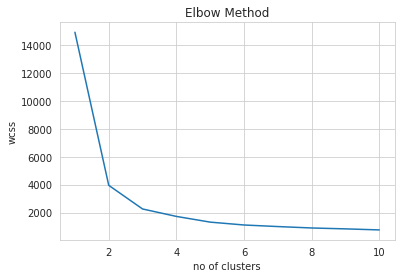

In [76]:
X=game_df3.iloc[:, 0:38].values
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans_model = kmeans.fit(X)
    wcss.append(kmeans.inertia_)     
plot.plot(range(1,11), wcss,)
plot.title('Elbow Method')
plot.xlabel('no of clusters')
plot.ylabel('wcss')
plot.show()

Based on the result of elbow method we can get the number of cluster=4

In [77]:
# common function to apply Kmean 
def applyKMean(array1, array2, color, marker):
  plot.plot()
  colors = color
  markers = marker
  plot.title('K-mean clustering of Foul VS Attempts')
  plot.xlabel('Attempt')
  plot.ylabel('Foul')
  plot.plot()
  for i, l in enumerate(kmeans_model.labels_):
    plot.plot(array1[i], array2[i], color=colors[l], marker=markers[l],ls='None')
    plot.xlim([0, 30])
    plot.ylim([0, 30])
  plot.show()

I have plotted clusters with labels to see positions of the clusters. I have used fouls per attempt as the basic features.

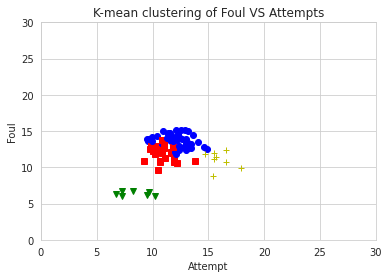

In [99]:
colors = ['b', 'g', 'r','y']
markers = ['o', 'v', 's','+']
kmeans_model = KMeans(4).fit(X)

# plot the cluster on a 2D plane
applyKMean(game_df3['Attempt'], game_df3['Foul'], colors, markers)

## **K-Mean Using Pytorch**

In [79]:
# installing library
!pip install kmeans-pytorch

In [81]:
import torch
import numpy as np
from kmeans_pytorch import kmeans, kmeans_predict

Here again I have used the same dataset as used in the above case.

In [82]:
# data
num_clusters = 4
x_val = game_df3.iloc[:, 0:2].values
x_val = torch.from_numpy(x_val)

In [83]:
# set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [84]:
# apply k-means
x_cluster_ids, cluster_centers = kmeans(
    X=x_val, num_clusters=num_clusters, distance='euclidean', device=device
)

running k-means on cpu..


[running kmeans]: 11it [00:00, 67.88it/s, center_shift=0.000000, iteration=11, tol=0.000100]


In [85]:
# print cluster and cluster centers
print(x_cluster_ids)
print(cluster_centers)

tensor([2, 1, 0, 3, 1, 2, 3, 3, 0, 1, 2, 0, 1, 3, 3, 1, 3, 3, 3, 0, 3, 2, 2, 3,
        2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2, 1, 1, 3,
        2, 0, 2, 0, 2, 3, 0, 3, 3, 3, 2, 0, 3, 3, 1, 2, 3, 3, 0, 0, 0, 3, 1, 3,
        3, 2, 0, 0, 0, 0, 2, 2, 2, 3, 3, 2, 2, 3, 0, 2, 3, 3, 0, 3, 3, 0, 3, 3,
        2])
tensor([[13.1213,  5.1808],
        [15.7361,  5.9189],
        [ 9.7182,  3.9556],
        [11.6926,  4.7226]])


In [86]:
# use more data columns 
y_val = game_df3.iloc[:, 2:4].values
y_val = torch.from_numpy(y_val)
y_val

tensor([[13.9737,  2.0877],
        [12.7476,  2.3762],
        [12.3407,  1.8000],
        [13.1250,  1.6667],
        [11.9143,  2.3048],
        [12.8158,  2.9211],
        [13.7299,  2.7488],
        [12.0096,  2.6220],
        [12.8086,  2.6986],
        [ 8.8565,  1.7560],
        [12.4651,  2.0640],
        [13.5134,  1.7968],
        [10.7487,  1.2193],
        [13.8895,  2.5698],
        [12.0427,  1.7393],
        [11.3583,  1.2620],
        [11.2941,  1.5080],
        [12.0672,  1.5224],
        [14.5814,  2.8140],
        [15.0351,  2.4561],
        [12.0292,  2.7018],
        [14.1316,  2.6711],
        [ 6.1226,  1.1226],
        [14.9716,  2.5308],
        [10.8158,  2.4211],
        [11.2647,  1.6838],
        [11.0902,  2.5113],
        [12.9661,  2.0169],
        [12.9684,  2.6000],
        [14.2129,  2.4000],
        [12.1842,  2.8684],
        [12.1753,  2.2990],
        [14.2679,  3.2010],
        [14.0481,  1.9091],
        [12.2605,  1.7143],
        [12.5190,  2

In [87]:
# predict cluster ids for y
y_cluster_ids = kmeans_predict(
    y_val, cluster_centers, 'euclidean', device=device
)

predicting on cpu..


In [88]:
print(y_cluster_ids)

tensor([0, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 0, 2, 0, 3, 2, 2, 3, 0, 0, 3, 0, 2, 0,
        2, 2, 2, 3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 2, 3, 3, 0,
        2, 0, 3, 3, 2, 2, 3, 0, 3, 1, 2, 3, 3, 0, 2, 3, 3, 0, 2, 0, 3, 3, 2, 2,
        0, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 2, 2, 0, 0, 2, 0, 2, 3, 0, 0, 0, 3, 0,
        2])


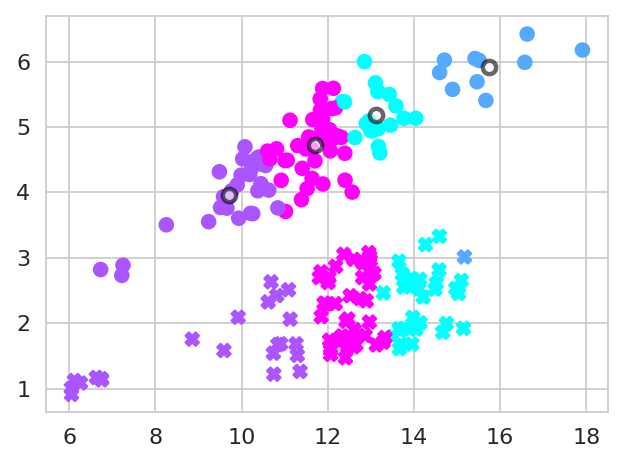

In [89]:
# plot
plot.figure(figsize=(4, 3), dpi=160)
plot.scatter(x_val[:, 0], x_val[:, 1], c=x_cluster_ids, cmap='cool')
plot.scatter(y_val[:, 0], y_val[:, 1], c=y_cluster_ids, cmap='cool', marker='X')
plot.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)

plot.tight_layout()
plot.show()

The above graph shows 4 clusters created as part of the k-mean clustering using Pytorch along with cluster centroids. The teams are clustered based on the features selected. More such clusters can be created using other combination of the features.

## **Clustering Using GMM algorithm**

In [93]:
game_df3

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,event_type2_,Key Pass,Failed through ball,Sending off,Own goal,location_,Attacking half,Defensive half,Centre of the box,Difficult angle and long range,Very close range,Penalty spot,Outside the box,Long range,More than 35 yards,More than 40 yards,None,Pass,Cross,Headed pass,Through ball,situation_,Open play,Set piece,Corner,Free kick,bodypart_,Head,Event team,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,40.061404,6.684211,3.201754,0.149123,0.035088,26.973684,2.500000,7.456140,2.947368,0.078947,0.236842,0.131579,4.008772,0.210526,0.175439,0.026316,43.447368,4.298246,1.736842,0.377193,0.271930,40.429825,8.008772,0.754386,0.649123,0.289474,40.429825,1.456140,AC Ajaccio,8.245614,3.500000,0.166667,1.429825,0.219298
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,42.095238,10.476190,2.585714,0.185714,0.052381,27.276190,3.204762,7.066667,3.733333,0.047619,0.442857,0.242857,6.976190,0.109524,0.090476,0.004762,44.919048,7.409524,2.271429,0.290476,0.504762,40.800000,12.452381,0.685714,1.042857,0.414286,40.800000,1.623810,AC Milan,12.971429,3.252381,0.300000,2.242857,0.300000
AS Monaco,12.333333,5.385185,12.340741,1.800000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,39.466667,9.029630,2.111111,0.081481,0.051852,25.548148,3.014815,6.281481,4.133333,0.059259,0.414815,0.192593,4.496296,0.081481,0.066667,0.014815,41.711111,5.585185,2.688889,0.362963,0.392593,38.407407,10.274074,0.637037,1.051852,0.370370,38.407407,2.177778,AS Monaco,10.155556,3.562963,0.259259,1.918519,0.562963
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,36.729167,8.239583,2.645833,0.083333,0.010417,24.458333,2.489583,6.437500,2.718750,0.072917,0.291667,0.104167,5.229167,0.177083,0.166667,0.020833,39.468750,5.447917,2.010417,0.437500,0.343750,36.687500,9.104167,0.718750,0.895833,0.302083,36.687500,1.750000,AS Nancy Lorraine,9.270833,3.302083,0.156250,1.739583,0.302083
AS Roma,15.509524,6.019048,11.914286,2.304762,0.080952,2.833333,13.100000,2.176190,0.547619,0.190476,40.690476,11.642857,2.176190,0.138095,0.028571,26.066667,3.161905,7.104762,4.190476,0.128571,0.428571,0.185714,6.757143,0.123810,0.095238,0.014286,43.033333,8.161905,2.257143,0.404762,0.819048,39.166667,13.261905,0.633333,1.223810,0.390476,39.166667,1.776190,AS Roma,13.733333,2.833333,0.371429,2.695238,0.409524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VfB Stuttgart,12.223529,4.864706,13.764706,1.917647,0.064706,2.729412,13.752941,2.476471,0.594118,0.135294,40.905882,8.952941,2.476471,0.141176,0.047059,26.547059,3.070588,7.335294,3.888235,0.111765,0.541176,0.123529,4.423529,0.200000,0.100000,0.011765,43.570588,5.735294,2.494118,0.529412,0.194118,40.300000,9.994118,0.805882,1.117647,0.305882,40.300000,2.282353,VfB Stuttgart,9.941176,3.347059,0.294118,2.105882,0.376471
VfL Wolfsburg,12.994652,4.946524,13.951872,1.679144,0.048128,2.759358,13.385027,2.192513,0.684492,0.128342,40.294118,10.149733,2.192513,0.101604,0.037433,26.395722,2.786096,7.213904,4.229947,0.106952,0.497326,0.085561,5.016043,0.139037,0.144385,0.010695,42.625668,6.631016,2.807487,0.454545,0.256684,39.780749,10.978610,0.534759,1.213904,0.267380,39.780749,2.443850,VfL Wolfsburg,10.550802,3.385027,0.256684,1.962567,0.443850
Villarreal,10.812865,4.666667,11.959064,2.292398,0.029240,2.807018,12.192982,2.719298,0.608187,0.140351,37.461988,7.929825,2.719298,0.093567,0.029240,25.228070,2.783626,6.725146,2.994152,0.064327,0.374269,0.140351,4.146199,0.052632,0.058480,0.017544,40.304094,5.403509,1.725146,0.251462,0.

In [149]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

## **Prepare Data for Modelling**

### Scaling the features

In [138]:
# total features
num_features = len(game_df3.columns)

In [139]:
scale_features = MinMaxScaler()
features_set = scale_features.fit_transform(game_df3)

### **Applying PCA to reduce the number of dimensions.**

In [140]:
pca = PCA()
pca = pca.fit(features_set)

In [141]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([4.39539489e-01, 1.74046783e-01, 6.43213772e-02, 4.66015774e-02,
       3.98025648e-02, 3.02982245e-02, 2.73286113e-02, 2.47081353e-02,
       2.14118996e-02, 1.85026799e-02, 1.52423652e-02, 1.25103961e-02,
       1.15164958e-02, 9.90115904e-03, 8.71599432e-03, 7.83642508e-03,
       6.43452875e-03, 5.53765115e-03, 5.04428567e-03, 4.95924151e-03,
       3.80152183e-03, 3.57573043e-03, 3.50389177e-03, 3.20459838e-03,
       2.67145627e-03, 2.11493089e-03, 1.66104139e-03, 1.62663787e-03,
       1.41458225e-03, 1.04124113e-03, 7.22664101e-04, 3.97076577e-04,
       3.60492791e-06, 1.04637285e-06, 7.43595256e-08, 1.53216867e-08,
       1.40055881e-09, 1.92498044e-32, 9.12369093e-33, 3.58592838e-33,
       3.58265777e-33, 3.21771080e-33, 3.21771080e-33])

### **Plotting PCA components**

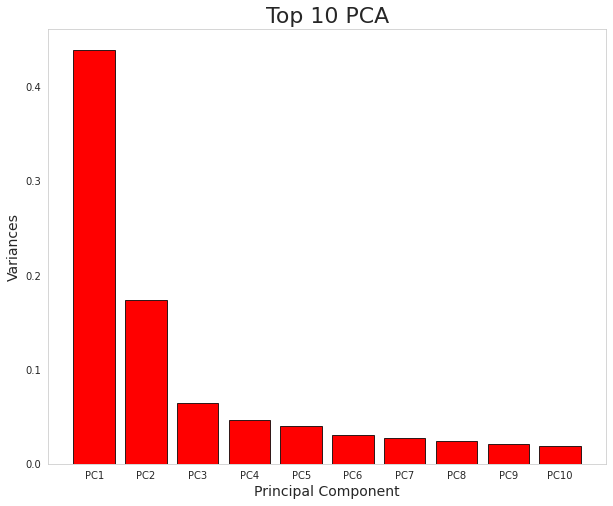

In [142]:
pca_ds = pd.DataFrame({'variance':pca.explained_variance_ratio_[0:10],
             'Principal Component':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})

plot.figure(figsize=(10,8))
plot.bar(pca_ds['Principal Component'], pca_ds['variance'], color ='red',
        width = 0.8, edgecolor='black',linewidth= 0.8)
plot.title('Top 10 PCA', fontsize=22)
plot.xlabel('Principal Component', fontsize=14)
plot.ylabel('Variances', fontsize=14)

plot.grid()
plot.show()

In [167]:
# implement PCA for 2 Principle components
pca = PCA(n_components= 2)
pca_data = pca.fit_transform(features_set)
X_principal = pd.DataFrame(pca_data) 
X_principal.columns = ['P1', 'P2']  
X_principal.head(2)

,P1,P2
0,0.063698,-0.917617
1,-0.846835,0.336404


In [172]:
gmm = GaussianMixture(n_components = 3, covariance_type="full", random_state=0) 
gmm = gmm.fit(X_principal)
labels_gmm = gmm.predict(X_principal)

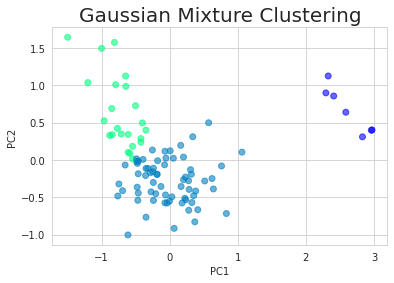

<Figure size 1440x1440 with 0 Axes>

In [207]:
# Visualizing the clustering 
plot.scatter(X_principal['P1'], X_principal['P2'],  
            c =labels_gmm, cmap =plot.cm.winter, alpha = 0.6) 
plot.xlabel('PC1')
plot.ylabel('PC2')
plot.title('Gaussian Mixture Clustering', fontsize=20)
plot.figure(figsize=(20,20))
plot.show() 

From the above graph it can be infered that after using PCA and applying GMM on the principle components the clusters are created clearly.

Clustering Using 